# Assignment 3 Question 1

## Ahmad Soni - 668564

## Nasiem Ayob - 1825850

Please find answers to questions at the end of the notebook


## Dimensionality reduction

In [1]:
#!pip install umap-learn minisom astroML
#!pip install seaborn

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import sdss_corrected_spectra
import seaborn as sns

from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn import manifold, neighbors

from scipy.sparse.csgraph import laplacian as csgraph_laplacian
import scipy.spatial as spt
from scipy.sparse.linalg import eigsh, eigs

from umap import UMAP

random_state = 42
np.random.seed(random_state)

In [3]:
import warnings

warnings.filterwarnings('ignore')

#### Application of PCA

For our astronomy use case, we are using the SDSS spectroscopic dataset. 
The SDSS spectra come from galaxies at a range of redshifts,
and have sections of unreliable or missing data due to sky absorption, cosmic rays, bad detector pixels,
or other effects. AstroML provides a set of spectra which have been moved to rest frame, corrected
for masking using an iterative PCA reconstruction technique, and resampled to 1000 common wavelength bins. 

The spectra can be downloaded using `fetch_sdss_corrected_spectra()`. In the following example we plot
15 of these spectra:

In [4]:
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
y = data['lineindex_cln']

# lookup for classes, 0-6
cdict = ['unknown', 'star', 'absorption galaxy',
         'galaxy', 'emission galaxy',
         'narrow-line QSO', 'broad-line QSO']



import pandas as pd

spectra_df = pd.DataFrame(spectra)
spectra_df['y'] = y
spectra_df = spectra_df.loc[(spectra_df['y'] >= 0) & (spectra_df['y'] <= 6)] # classes between 0 & 6
#spectra_df['y'] = spectra_df['y'].replace([0, 1, 2, 3, 4, 5, 6],cdict) # Replacing y values with string labels
df = spectra_df.copy().drop('y', axis=1)# All x values

In [5]:
spectra_df['y'].values

array([4, 3, 3, ..., 4, 2, 4], dtype=int32)

In [6]:
spectra[:4]

array([[ 4.9201283,  5.1662374,  6.073041 , ...,  7.5093303,  7.970523 ,
         7.9843907],
       [ 2.189293 ,  2.1868663,  2.1844583, ..., 12.837092 , 12.934673 ,
        12.810533 ],
       [ 2.7451353,  2.738469 ,  3.368032 , ...,  9.2907915,  9.108875 ,
         8.385379 ],
       [ 3.1576953,  3.3948607,  4.29607  , ..., 20.881233 , 20.43282  ,
        19.751265 ]], dtype=float32)

In [7]:
len(spectra)

4000

In [8]:

#----------------------------------------------------------------------
# Use pre-computed PCA to reconstruct spectra
spectra_raw = data['spectra']
spectra_corr = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#------------------------------------------------------------
# select random spectra
nrows = 5
ncols = 3
ind = np.random.randint(spectra_corr.shape[0], size=nrows * ncols)
spec_sample_raw = spectra_raw[ind]
spec_sample_corr = spectra_corr[ind]

We show the SDSS downloaded spectra with black, and our corrected spectra with blue.

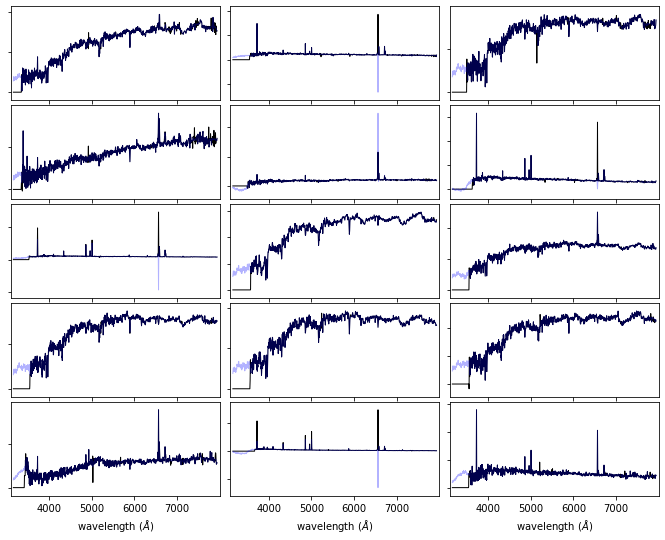

In [9]:
fig = plt.figure(figsize=(10, 8))

fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

for i in range(ncols):
    for j in range(nrows):
        ax = fig.add_subplot(nrows, ncols, ncols * j + 1 + i)
        ax.plot(wavelengths, spec_sample_raw[ncols * j + i], '-k', lw=1)
        ax.plot(wavelengths, spec_sample_corr[ncols * j + i], '-b', lw=1, alpha=0.3) # , c='blue')               
        ax.set_xlim(3100, 7999)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < nrows - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            plt.xlabel(r'wavelength $(\AA)$')

        ylim = ax.get_ylim()
        dy = 0.05 * (ylim[1] - ylim[0])
        ax.set_ylim(ylim[0] - dy, ylim[1] + dy)

plt.show()

### PCA Reconstruction of a spectrum

Reconstruction of spectrum, ${x}(k)$, from the
eigenvectors, ${e}_i(k)$ 

$$  {x}_i(k) = {\mu}(k) + \sum_j^R \theta_{ij} {e}_j(k),$$

Truncating this expansion (i.e., $r<R$)

$$
{x}_i(k) = {\mu}(k) + \sum_i^{r<R} \theta_i {e}_i(k),
$$

- eigenvectors ordered by their associated eigenvalues 
- eigenvalues reflect variance  within each eigenvector (sum of the eigenvalues is total variance of the system).
- project a each spectrum onto these first few eigenspectra is a compression of the data 

This is the sense in which PCA gives for dimensionality reduction.

In the following example, the input spectrum is shown in gray,
and the partial reconstruction for progressively more terms is shown in black. 
The top panel shows only the mean of the set of spectra. By the time 20 PCA components are added,
the reconstruction is very close to the input, as indicated by the expected total variance of 94%.

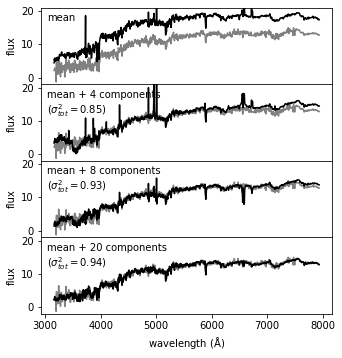

In [10]:
#------------------------------------------------------------
# Compute PCA components
#  because the spectra have been reconstructed from masked values, 
#  we'll use the values computed
#  in the file compute_sdss_pca.py
evals = data['evals'] ** 2
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]
evecs = data['evecs']
spec_mean = spectra_corr.mean(0)

#------------------------------------------------------------
# Find the coefficients of a particular spectrum
spec = spectra_corr[1]
coeff = np.dot(evecs, spec - spec_mean)

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

for i, n in enumerate([0, 4, 8, 20]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

### Eigenvalues

The eigenvalues for the PCA decomposition of the SDSS spectra described in the previous section. The top panel
shows the decrease in eigenvalue as a function of the number of eigenvectors, with a break in the distribution
at ten eigenvectors. The lower panel shows the cumulative sum of eigenvalues normalized to unity. 
94% of the variance in the SDSS spectra can be captured using the first ten eigenvectors.

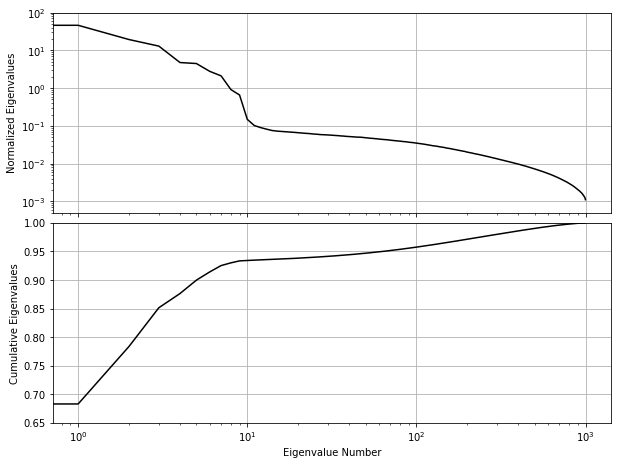

In [11]:
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(hspace=0.05, bottom=0.12)

ax = fig.add_subplot(211, xscale='log', yscale='log')
ax.grid()
ax.plot(evals, c='k')
ax.set_ylabel('Normalized Eigenvalues')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylim(5E-4, 100)

ax = fig.add_subplot(212, xscale='log')
ax.grid()
ax.semilogx(evals_cs, color='k')
ax.set_xlabel('Eigenvalue Number')
ax.set_ylabel('Cumulative Eigenvalues')
ax.set_ylim(0.65, 1.00)

plt.show()

## Comparing LLE, ISOMAP, UMAP

In [12]:
def get_eigenvalues(X, n_neighbours, n_clusters):
    """ Helper function that will construct a nearest neighbours
    similarity graph from X, then compute a normalised Laplacian for this graph,
    and then calculate the smallest n_clusters eigenvalues.
    
    This is useful for identifying the number of clusters expected
    in the data when using SpectralEmbedding
    """
    K = kneighbors_graph(X, n_neighbors=n_neighbours, include_self=True)

    K = 0.5 * (K + K.T)


    # diagonal matrix
    L, D = csgraph_laplacian(
            K, normed=True, return_diag=True
        )

    L = L.tocoo()
    diag_idx = L.row == L.col
    L.data[diag_idx] = 1
    # If the matrix has a small number of diagonals (as in the
    # case of structured matrices coming from images), the
    # dia format might be best suited for matvec products:
    n_diags = np.unique(L.row - L.col).size
    if n_diags <= 7:
        # 3 or less outer diagonals on each side
        L = L.todia()
    else:
        # csr has the fastest matvec and is thus best suited to
        # arpack
        L = L.tocsr()

    L *= -1
    vals, vecs = eigsh(
        L, k=n_clusters, sigma=1.0, which="LM", tol=1e-5
    )

    # sort these based on the eigenvalues
    vecs = vecs[:,np.argsort(vals)]
    vals = vals[np.argsort(vals)]
    plt.plot(vals)
    
    return vecs, vals


def plot_2d(X, labels, title):
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.jet)
    plt.xlabel('coefficient 1')
    plt.ylabel('coefficient 2')
    plt.title(title)
    plt.legend()
    
def plot_ed(X1, X2, labels, title):
    fig, axs = plt.subplots(2) 
    fig.suptitle('Vertically stacked subplots') 
    axs[0].scatter(X1[:, 0], X1[:, 1], c=labels, cmap=plt.cm.jet)
    axs[1].scatter(X2[:, 0], X2[:, 1], c=labels, cmap=plt.cm.jet)
    axs[0].xlabel('coefficient 1')
    axs[0].ylabel('coefficient 2')
    plt.title(title)
    

def plot_ed1(X1, X2, labels, title):
    fig = plt.figure(figsize=(6.4, 4.8))
    fig.subplots_adjust(hspace=0.05, bottom=0.12)
    
    ax = fig.add_subplot(211)
    #ax.grid()
    ax.scatter(X1[:, 0], X1[:, 1], c=labels, cmap=plt.cm.jet)
    ax.set_ylabel('coefficient 2')
    #ax.xaxis.set_major_formatter(plt.NullFormatter())
    
    ax = fig.add_subplot(212)
    #ax.grid()
    ax.scatter(X2[:, 0], X2[:, 1], c=labels, cmap=plt.cm.jet)
    ax.set_xlabel('coefficient 1')
    ax.set_ylabel('coefficient 2')
    
    plt.show()
    
    

def mask_outliers(X):
    BT = neighbors.BallTree(X)
    dist, ind = BT.query(X, 10)
    dist_to_n = dist[:, -1]
    dist_to_n -= dist_to_n.mean()
    std = np.std(dist_to_n)
    flag = (dist_to_n > 0.25 * std)
    print(" - removing {0} outliers for plot".format(flag.sum()))
    return flag

### Isomap

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

spectra = preprocessing.normalize(df.values)
#spectra = StandardScaler().fit_transform(df.values)
#y = preprocessing.normalize(y)
#StandardScaler().fit_transform(spectra)
print(spectra)

[[0.01561043 0.01639127 0.01926835 ... 0.02382536 0.02528862 0.02533262]
 [0.00670018 0.00669275 0.00668538 ... 0.03928702 0.03958566 0.03920574]
 [0.01120988 0.01118265 0.0137535  ... 0.03793934 0.03719648 0.03424205]
 ...
 [0.00876579 0.01004222 0.01106105 ... 0.02363359 0.03494343 0.02868021]
 [0.00819846 0.00924495 0.01032879 ... 0.03921879 0.03613766 0.03775293]
 [0.00986118 0.01037061 0.01260019 ... 0.03539927 0.04028117 0.03950021]]


In [14]:
import pandas as pd

df = pd.DataFrame(spectra)
y = spectra_df['y'].values
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.015610,0.016391,0.019268,0.019467,0.018783,0.020817,0.016089,0.018725,0.019159,0.018467,0.019178,0.019164,0.020128,0.020923,0.021846,0.022199,0.022940,0.022473,0.022891,0.022200,0.023699,0.022861,0.023866,0.020184,0.021524,0.022606,0.024521,0.023037,0.025198,0.023930,0.023542,0.025363,0.024864,0.026102,0.026854,0.027128,0.026502,0.027784,0.027929,0.027479,...,0.027091,0.024734,0.031905,0.029850,0.029142,0.026862,0.026094,0.029680,0.026268,0.026472,0.027933,0.028798,0.026314,0.028420,0.028471,0.027504,0.027205,0.027719,0.027945,0.027603,0.024767,0.029217,0.027458,0.029612,0.026260,0.027935,0.028614,0.027319,0.027460,0.029882,0.026631,0.025458,0.027163,0.026762,0.027277,0.026476,0.028260,0.023825,0.025289,0.025333
1,0.006700,0.006693,0.006685,0.006678,0.008773,0.008586,0.006656,0.006474,0.006748,0.007168,0.003630,0.002787,0.004258,-0.003903,0.011058,0.014200,0.005632,0.006446,0.011532,0.009238,0.010599,0.003081,0.003228,0.004461,0.010141,0.007124,0.013895,0.006772,0.019712,0.006081,0.003594,0.011223,0.015161,0.004143,0.004861,0.005648,0.010323,0.009368,0.012450,0.000752,...,0.040417,0.038860,0.038906,0.040071,0.040293,0.040086,0.039698,0.039930,0.039465,0.039484,0.040032,0.040679,0.040846,0.039723,0.039942,0.040350,0.040628,0.040721,0.040437,0.040474,0.040628,0.040752,0.040973,0.041509,0.041177,0.040165,0.040407,0.040742,0.040692,0.040998,0.040828,0.040393,0.040498,0.040602,0.040063,0.039990,0.039293,0.039287,0.039586,0.039206
2,0.011210,0.011183,0.013754,0.013137,0.014055,0.015057,0.011406,0.012963,0.013014,0.013112,0.012300,0.012443,0.013131,0.013790,0.014546,0.014932,0.014555,0.014799,0.014251,0.014687,0.015548,0.015420,0.014184,0.013475,0.013293,0.014112,0.014621,0.014384,0.014412,0.015008,0.014287,0.014821,0.016098,0.017235,0.017679,0.015866,0.016237,0.016465,0.016740,0.015982,...,0.041334,0.038212,0.037152,0.040127,0.041633,0.040612,0.035289,0.036157,0.040236,0.039234,0.039923,0.040503,0.040692,0.039546,0.043941,0.040274,0.037602,0.040396,0.040164,0.040406,0.040488,0.040730,0.037383,0.044905,0.041500,0.047918,0.040992,0.042475,0.040790,0.041184,0.040922,0.040462,0.040656,0.041832,0.039948,0.045970,0.035727,0.037939,0.037196,0.034242
3,0.006325,0.006801,0.008606,0.007361,0.009177,0.009282,0.006915,0.007103,0.007465,0.007844,0.006480,0.006754,0.007412,0.008030,0.008584,0.008713,0.008676,0.007274,0.007067,0.007943,0.008867,0.009406,0.007632,0.007607,0.007202,0.007728,0.007653,0.008266,0.007850,0.008750,0.008213,0.008549,0.010265,0.010613,0.011018,0.009528,0.010050,0.010023,0.010118,0.009677,...,0.042047,0.040928,0.040554,0.042141,0.043068,0.042759,0.042342,0.042607,0.042171,0.041839,0.041039,0.043170,0.041156,0.040505,0.041690,0.043284,0.043513,0.043645,0.043263,0.043451,0.042987,0.044119,0.043414,0.044027,0.042864,0.040782,0.043425,0.045034,0.043391,0.044517,0.044867,0.042891,0.043976,0.042379,0.043910,0.043077,0.039949,0.041829,0.040931,0.039565
4,0.006214,0.006446,0.008802,0.006764,0.008996,0.009263,0.006545,0.006877,0.007610,0.007963,0.006177,0.006717,0.007431,0.008009,0.008312,0.008593,0.008870,0.007214,0.006738,0.007619,0.008864,0.009281,0.007462,0.007725,0.006907,0.007692,0.007362,0.008076,0.007393,0.008608,0.008086,0.008195,0.009783,0.010492,0.011059,0.009063,0.009635,0.010128,0.009756,0.009356,...,0.049743,0.043237,0.048795,0.042773,0.036215,0.042829,0.045339,0.041443,0.039880,0.038968,0.040647,0.045948,0.042762,0.040611,0.043142,0.042484,0.044562,0.044725,0.041530,0.043495,0.043605,0.043748,0.044045,0.044615,0.043630,0.044876,0.040559,0.044687,0.047346,0.043831,0.043953,0.043495,0.043599,0.043888,0.043243,0.042873,0.041715,0.045352,0.038711,0.040261


No handles with labels found to put in legend.


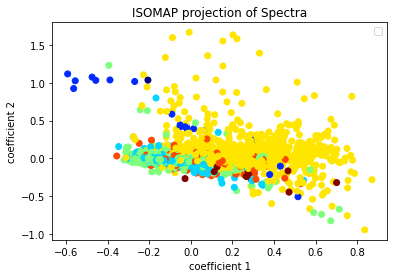

In [25]:
iso = Isomap(n_components=20, n_neighbors=30)

ISOMAP_PROJECTION = iso.fit_transform(df.values)

plot_2d(ISOMAP_PROJECTION, y, 'ISOMAP projection of Spectra')



### UMAP


No handles with labels found to put in legend.


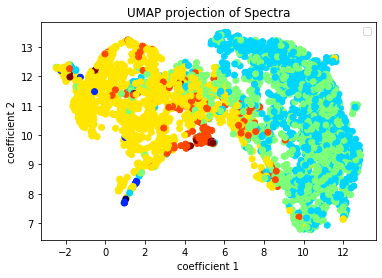

In [24]:
import umap

umap_obj = UMAP(
    n_components=20, 
    metric="euclidean",
    n_neighbors=30, 
    min_dist=0.5,
    random_state=random_state
)

reducer = umap.UMAP(random_state=42)

UMAP_PROJECTION = reducer.fit_transform(df.values)

plot_2d(UMAP_PROJECTION, y, 'UMAP projection of Spectra')

### Spectral Embedding

No handles with labels found to put in legend.


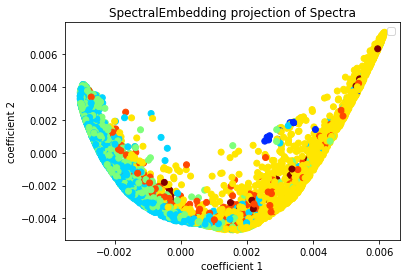

In [21]:
se = SpectralEmbedding(n_components=10, n_neighbors=30, random_state=random_state) 

SE_PROJECTION = se.fit_transform(df.values)

plot_2d(SE_PROJECTION, y, 'SpectralEmbedding projection of Spectra')

In [ ]:
SE_PROJECTION[0]

### LLE

No handles with labels found to put in legend.


 - removing 778 outliers for plot


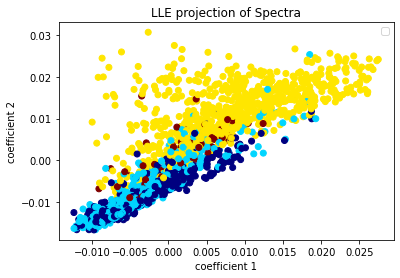

In [20]:
lle = LocallyLinearEmbedding(n_components=10, n_neighbors=30, method='modified', eigen_solver='dense', random_state=random_state) 

LLE_PROJECTION = lle.fit_transform(df.values)

# Note: the LLE projection has some outliers that can make the plot
# look weird.  Use the following to find the mask to remove the outliers
# for the plot
flag = mask_outliers(LLE_PROJECTION)


plot_2d(LLE_PROJECTION[~flag], y[~flag], 'LLE projection of Spectra')

#### ISOMAP

Sample size: 50 % n_neighbours: 5 n_components 2
Sample size: 50 % n_neighbours: 5 n_components 4
Sample size: 50 % n_neighbours: 5 n_components 6
Sample size: 50 % n_neighbours: 15 n_components 2
Sample size: 50 % n_neighbours: 15 n_components 4
Sample size: 50 % n_neighbours: 15 n_components 6
Sample size: 50 % n_neighbours: 25 n_components 2
Sample size: 50 % n_neighbours: 25 n_components 4
Sample size: 50 % n_neighbours: 25 n_components 6
Sample size: 75 % n_neighbours: 5 n_components 2
Sample size: 75 % n_neighbours: 5 n_components 4
Sample size: 75 % n_neighbours: 5 n_components 6
Sample size: 75 % n_neighbours: 15 n_components 2
Sample size: 75 % n_neighbours: 15 n_components 4
Sample size: 75 % n_neighbours: 15 n_components 6
Sample size: 75 % n_neighbours: 25 n_components 2
Sample size: 75 % n_neighbours: 25 n_components 4
Sample size: 75 % n_neighbours: 25 n_components 6
Sample size: 100 % n_neighbours: 5 n_components 2
Sample size: 100 % n_neighbours: 5 n_components 4
Sample

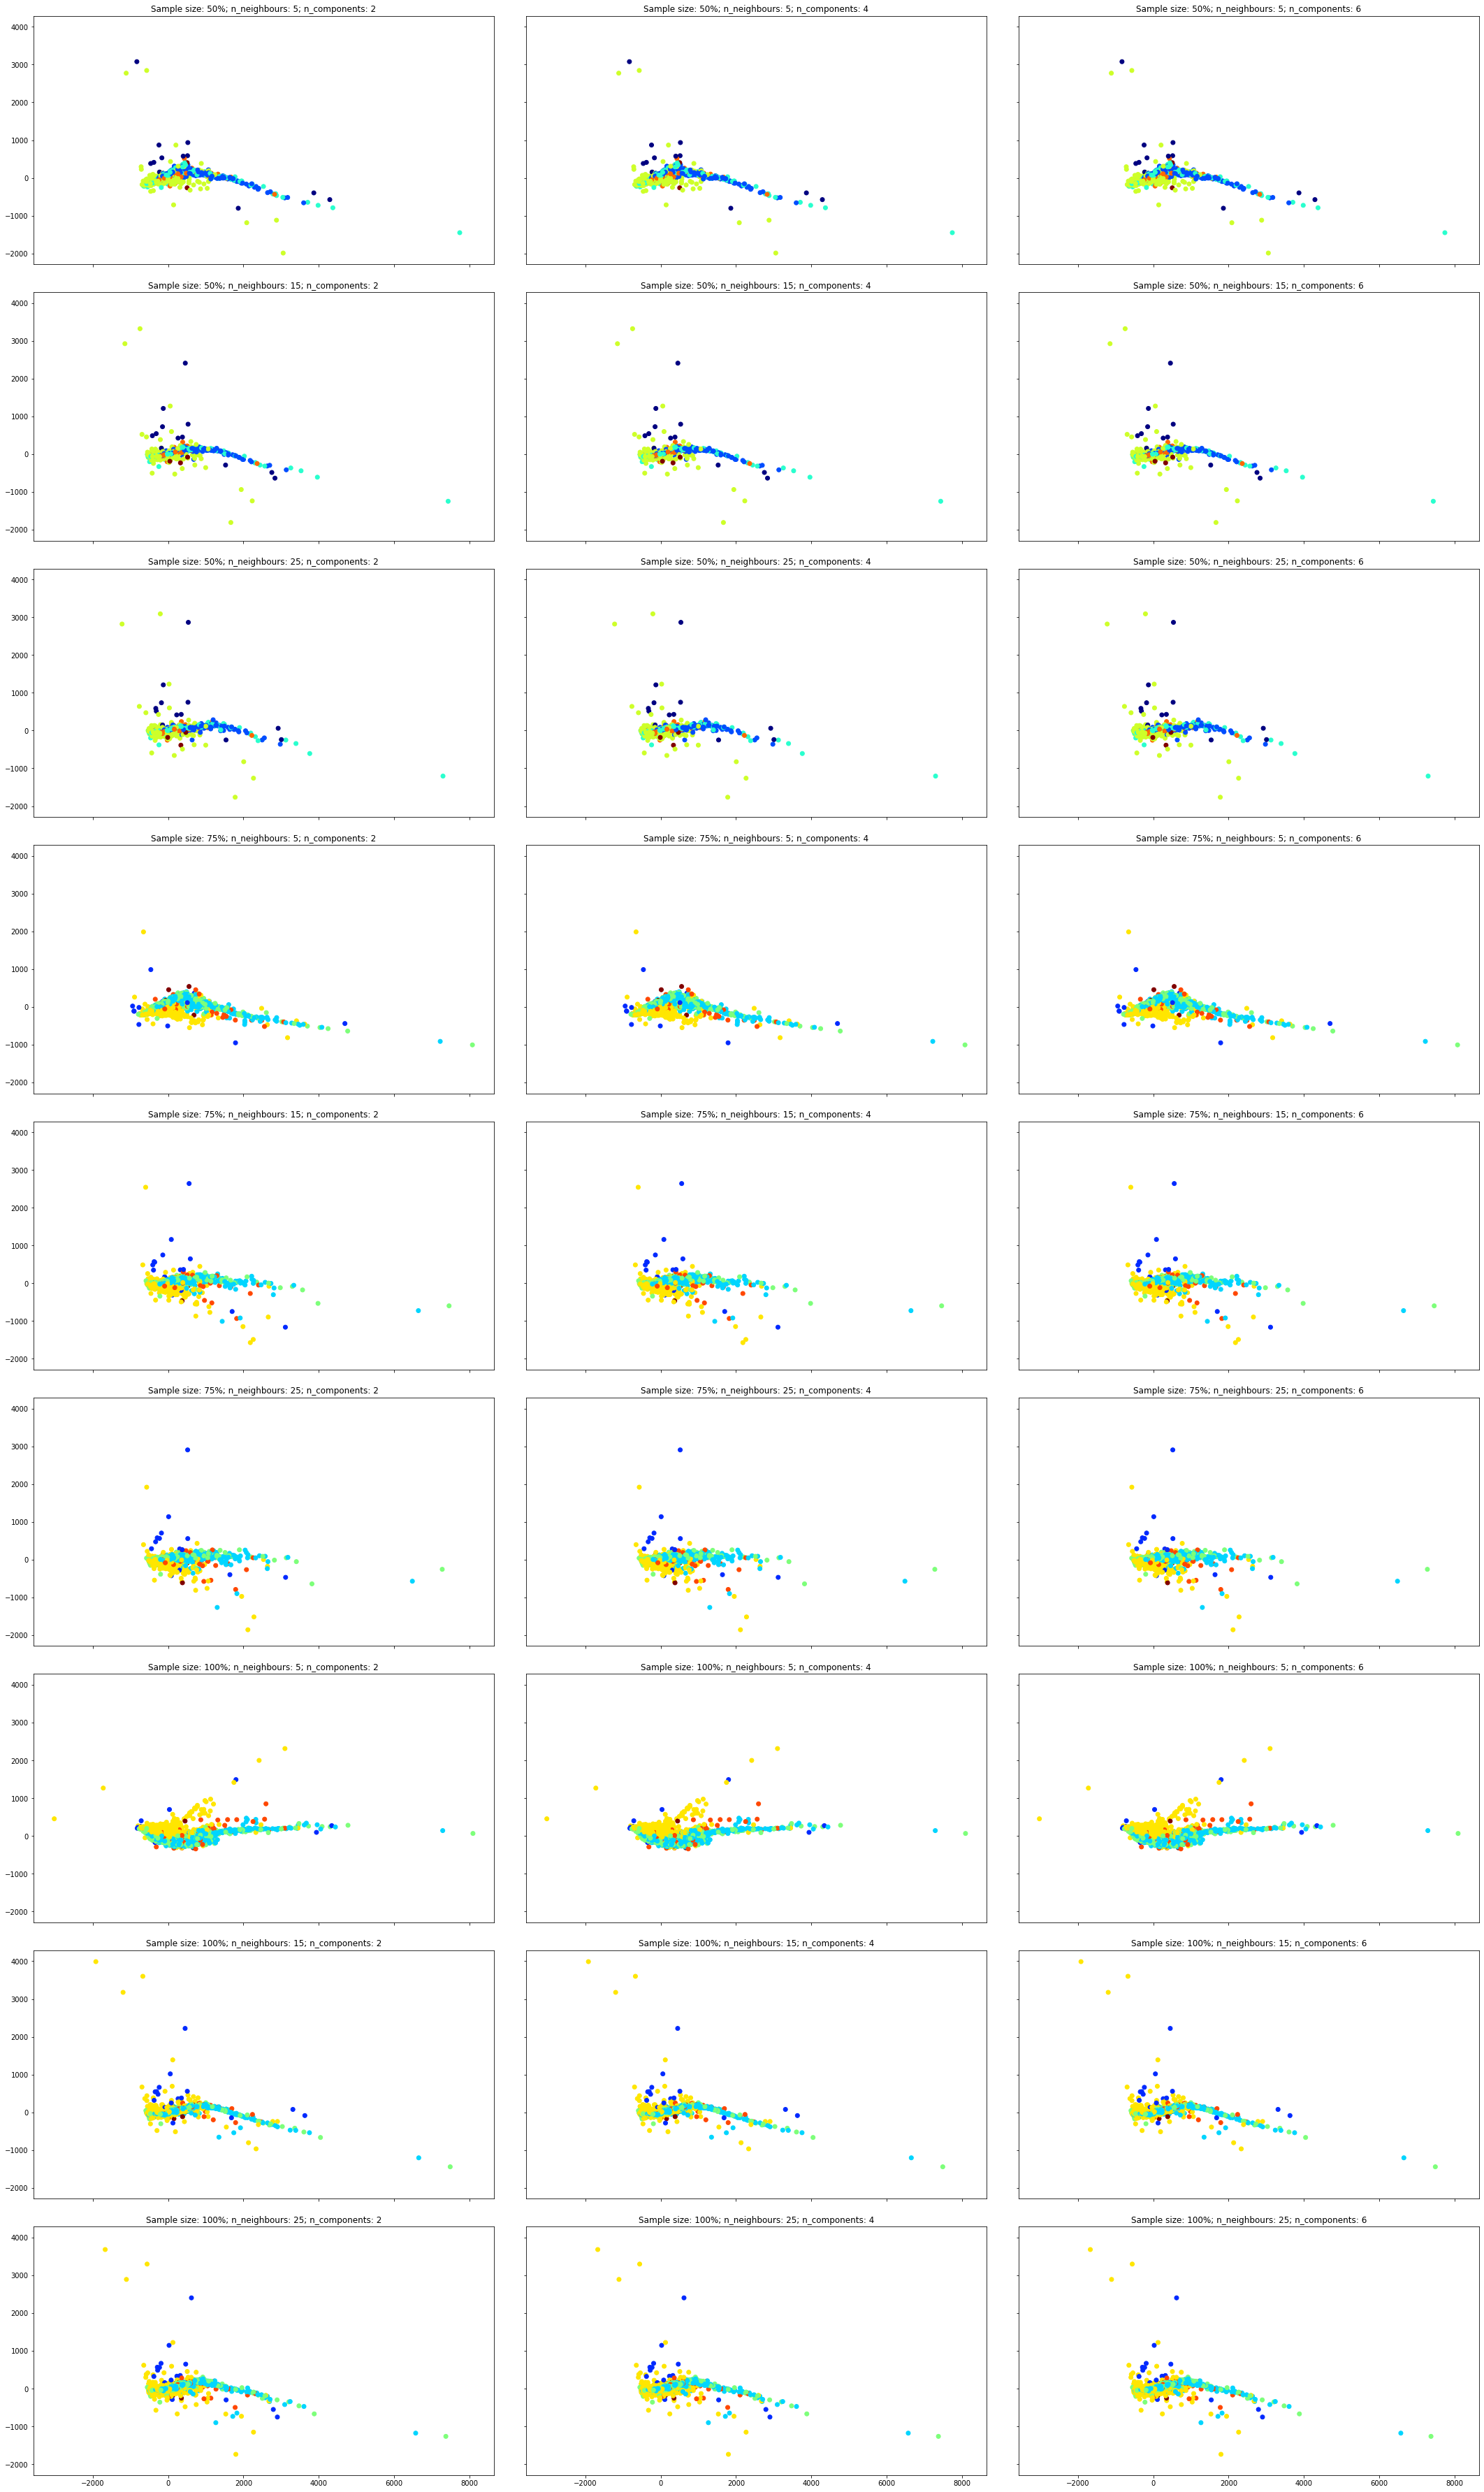

In [26]:
import numpy as np

fig, axes = plt.subplots(ncols=3,nrows=9, sharex=True, sharey=True, figsize=(30, 50));

axes_list = axes.flat

k = 0

fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.2, top=0.95, hspace=0.2)

fig.tight_layout(pad=3.0)

# Components range
min_comps = 2
max_comps = 8
comps_range = range(min_comps, max_comps, 2)


# Neighbours range
min_nbs = 5
max_nbs = 35
nbs_range = range(min_nbs, max_nbs, 10)


# Datasets
sizes = [50,75,100]

for i in sizes:
    df_samp = spectra_df.sample(n = int(len(spectra_df)*(i/100))) # A random sample of size i%
    y_temp = df_samp['y'].values # y values from random sample
    temp_df = df_samp.drop('y', axis=1) # all the x values from random sample
    
    # iterate through number of neighbours
    for n in nbs_range:
        # iterate through number of components
        for c in comps_range:
            # get the coherence score for the given parameters
            iso = Isomap(n_components=c, n_neighbors=n)
            
            ISOMAP_PROJECTION = iso.fit_transform(temp_df.values)
            
            print("Sample size:", i,"%","n_neighbours:", n, "n_components", c)
            
            title = "Sample size: " + str(i) + "%;" + " " + "n_neighbours: " + str(n) + ";" + " " + "n_components: " + str(c)
            
            X = ISOMAP_PROJECTION
            labels = y_temp 
            
            axes_list[k].scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.jet)
            axes_list[k].title.set_text(title) 
            k += 1
                

#### UMAP

Sample size: 50 % n_neighbours: 5 n_components 2
Sample size: 50 % n_neighbours: 5 n_components 4
Sample size: 50 % n_neighbours: 5 n_components 6
Sample size: 50 % n_neighbours: 15 n_components 2
Sample size: 50 % n_neighbours: 15 n_components 4
Sample size: 50 % n_neighbours: 15 n_components 6
Sample size: 50 % n_neighbours: 25 n_components 2
Sample size: 50 % n_neighbours: 25 n_components 4
Sample size: 50 % n_neighbours: 25 n_components 6
Sample size: 75 % n_neighbours: 5 n_components 2
Sample size: 75 % n_neighbours: 5 n_components 4
Sample size: 75 % n_neighbours: 5 n_components 6
Sample size: 75 % n_neighbours: 15 n_components 2
Sample size: 75 % n_neighbours: 15 n_components 4
Sample size: 75 % n_neighbours: 15 n_components 6
Sample size: 75 % n_neighbours: 25 n_components 2
Sample size: 75 % n_neighbours: 25 n_components 4
Sample size: 75 % n_neighbours: 25 n_components 6
Sample size: 100 % n_neighbours: 5 n_components 2
Sample size: 100 % n_neighbours: 5 n_components 4
Sample

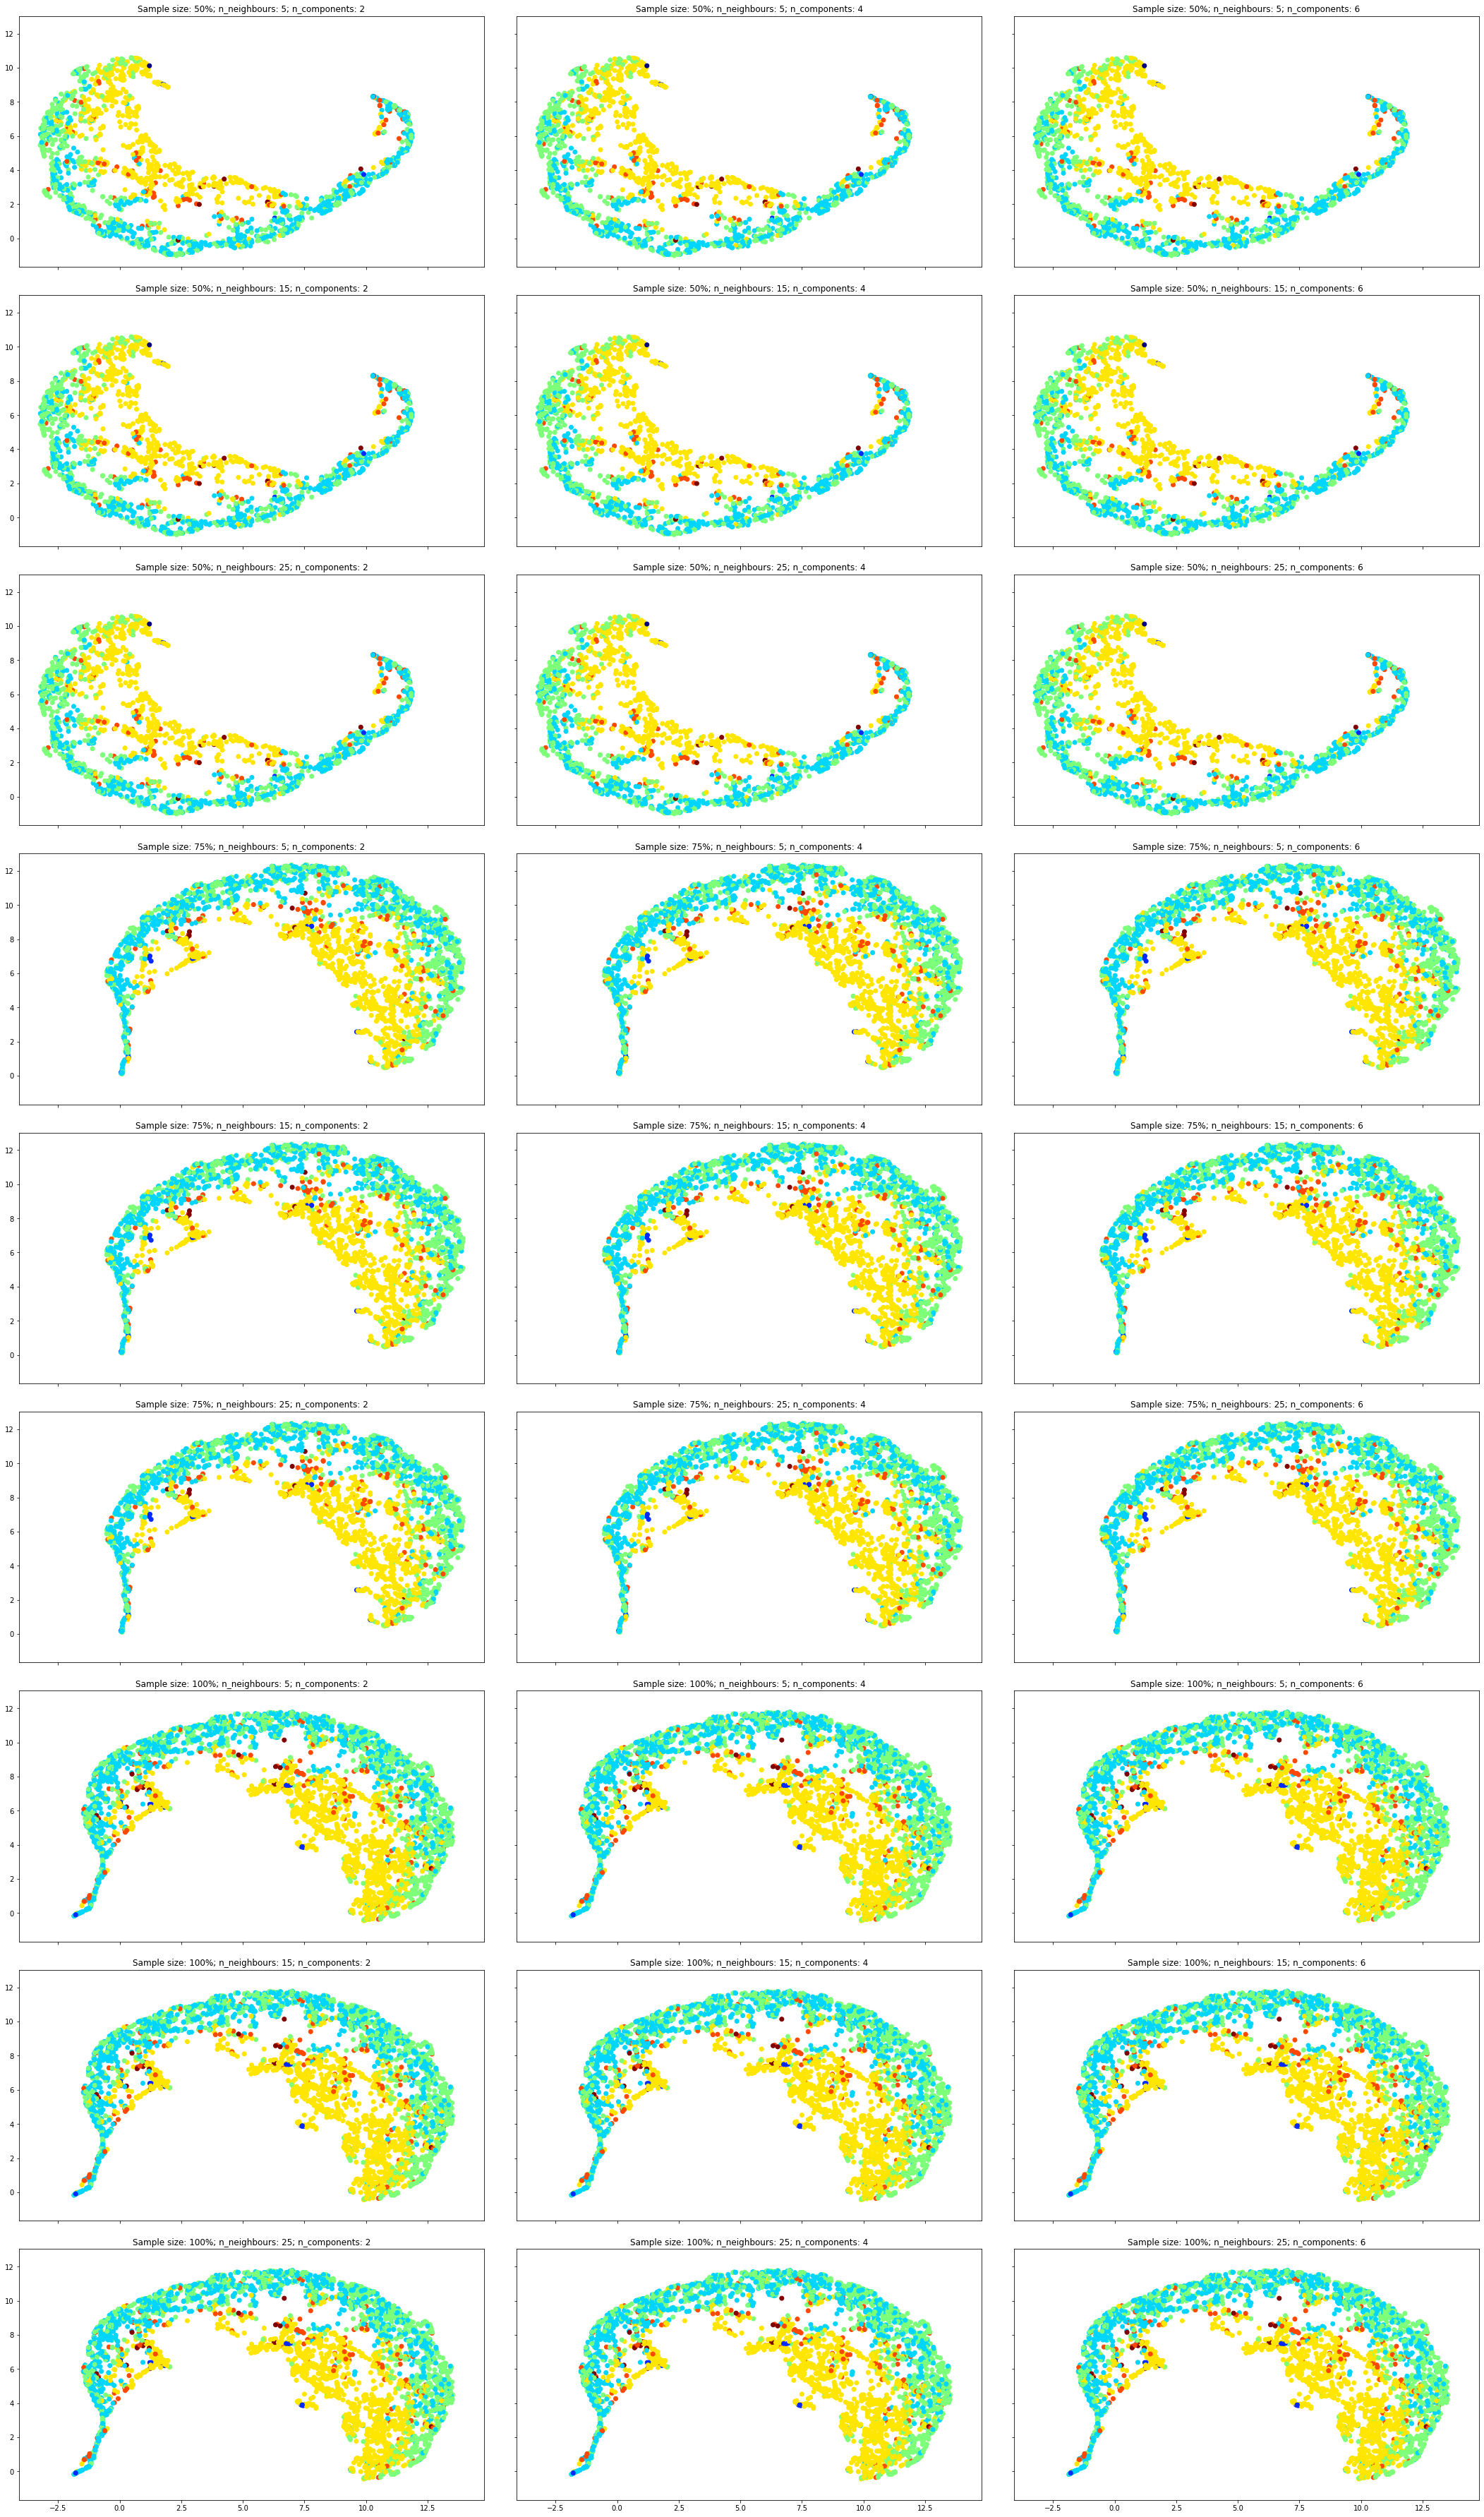

In [27]:
import numpy as np

fig, axes = plt.subplots(ncols=3,nrows=9, sharex=True, sharey=True, figsize=(30, 50));

axes_list = axes.flat

k = 0

fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.2, top=0.95, hspace=0.2)

fig.tight_layout(pad=3.0)

# Components range
min_comps = 2
max_comps = 8
comps_range = range(min_comps, max_comps, 2)


# Neighbours range
min_nbs = 5
max_nbs = 35
nbs_range = range(min_nbs, max_nbs, 10)


# Datasets
sizes = [50,75,100]

for i in sizes:
    df_samp = spectra_df.sample(n = int(len(spectra_df)*(i/100))) # A random sample of size i%
    y_temp = df_samp['y'].values # y values from random sample
    temp_df = df_samp.drop('y', axis=1) # all the x values from random sample
    
    # iterate through number of neighbours
    for n in nbs_range:
        # iterate through number of components
        for c in comps_range:
            # get the coherence score for the given parameters
            iso = Isomap(n_components=c, n_neighbors=n)
            
            ISOMAP_PROJECTION = iso.fit_transform(temp_df.values)
            
            print("Sample size:", i,"%","n_neighbours:", n, "n_components", c)
            
            title = "Sample size: " + str(i) + "%;" + " " + "n_neighbours: " + str(n) + ";" + " " + "n_components: " + str(c)
            
            umap_obj = UMAP(
                n_components=c, 
                metric="euclidean",
                n_neighbors=n, 
                min_dist=0.1,
                random_state=random_state
            )
            
            
            UMAP_PROJECTION = umap.UMAP(random_state=42).fit_transform(temp_df.values)
            
            X = UMAP_PROJECTION
            labels = y_temp
            
            axes_list[k].scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.jet)
            axes_list[k].title.set_text(title) 
            k += 1

#### Spectral Embedding

Sample size: 50 % n_neighbours: 5 n_components 2
Sample size: 50 % n_neighbours: 5 n_components 4
Sample size: 50 % n_neighbours: 5 n_components 6
Sample size: 50 % n_neighbours: 15 n_components 2
Sample size: 50 % n_neighbours: 15 n_components 4
Sample size: 50 % n_neighbours: 15 n_components 6
Sample size: 50 % n_neighbours: 25 n_components 2
Sample size: 50 % n_neighbours: 25 n_components 4
Sample size: 50 % n_neighbours: 25 n_components 6
Sample size: 75 % n_neighbours: 5 n_components 2
Sample size: 75 % n_neighbours: 5 n_components 4
Sample size: 75 % n_neighbours: 5 n_components 6
Sample size: 75 % n_neighbours: 15 n_components 2
Sample size: 75 % n_neighbours: 15 n_components 4
Sample size: 75 % n_neighbours: 15 n_components 6
Sample size: 75 % n_neighbours: 25 n_components 2
Sample size: 75 % n_neighbours: 25 n_components 4
Sample size: 75 % n_neighbours: 25 n_components 6
Sample size: 100 % n_neighbours: 5 n_components 2
Sample size: 100 % n_neighbours: 5 n_components 4
Sample

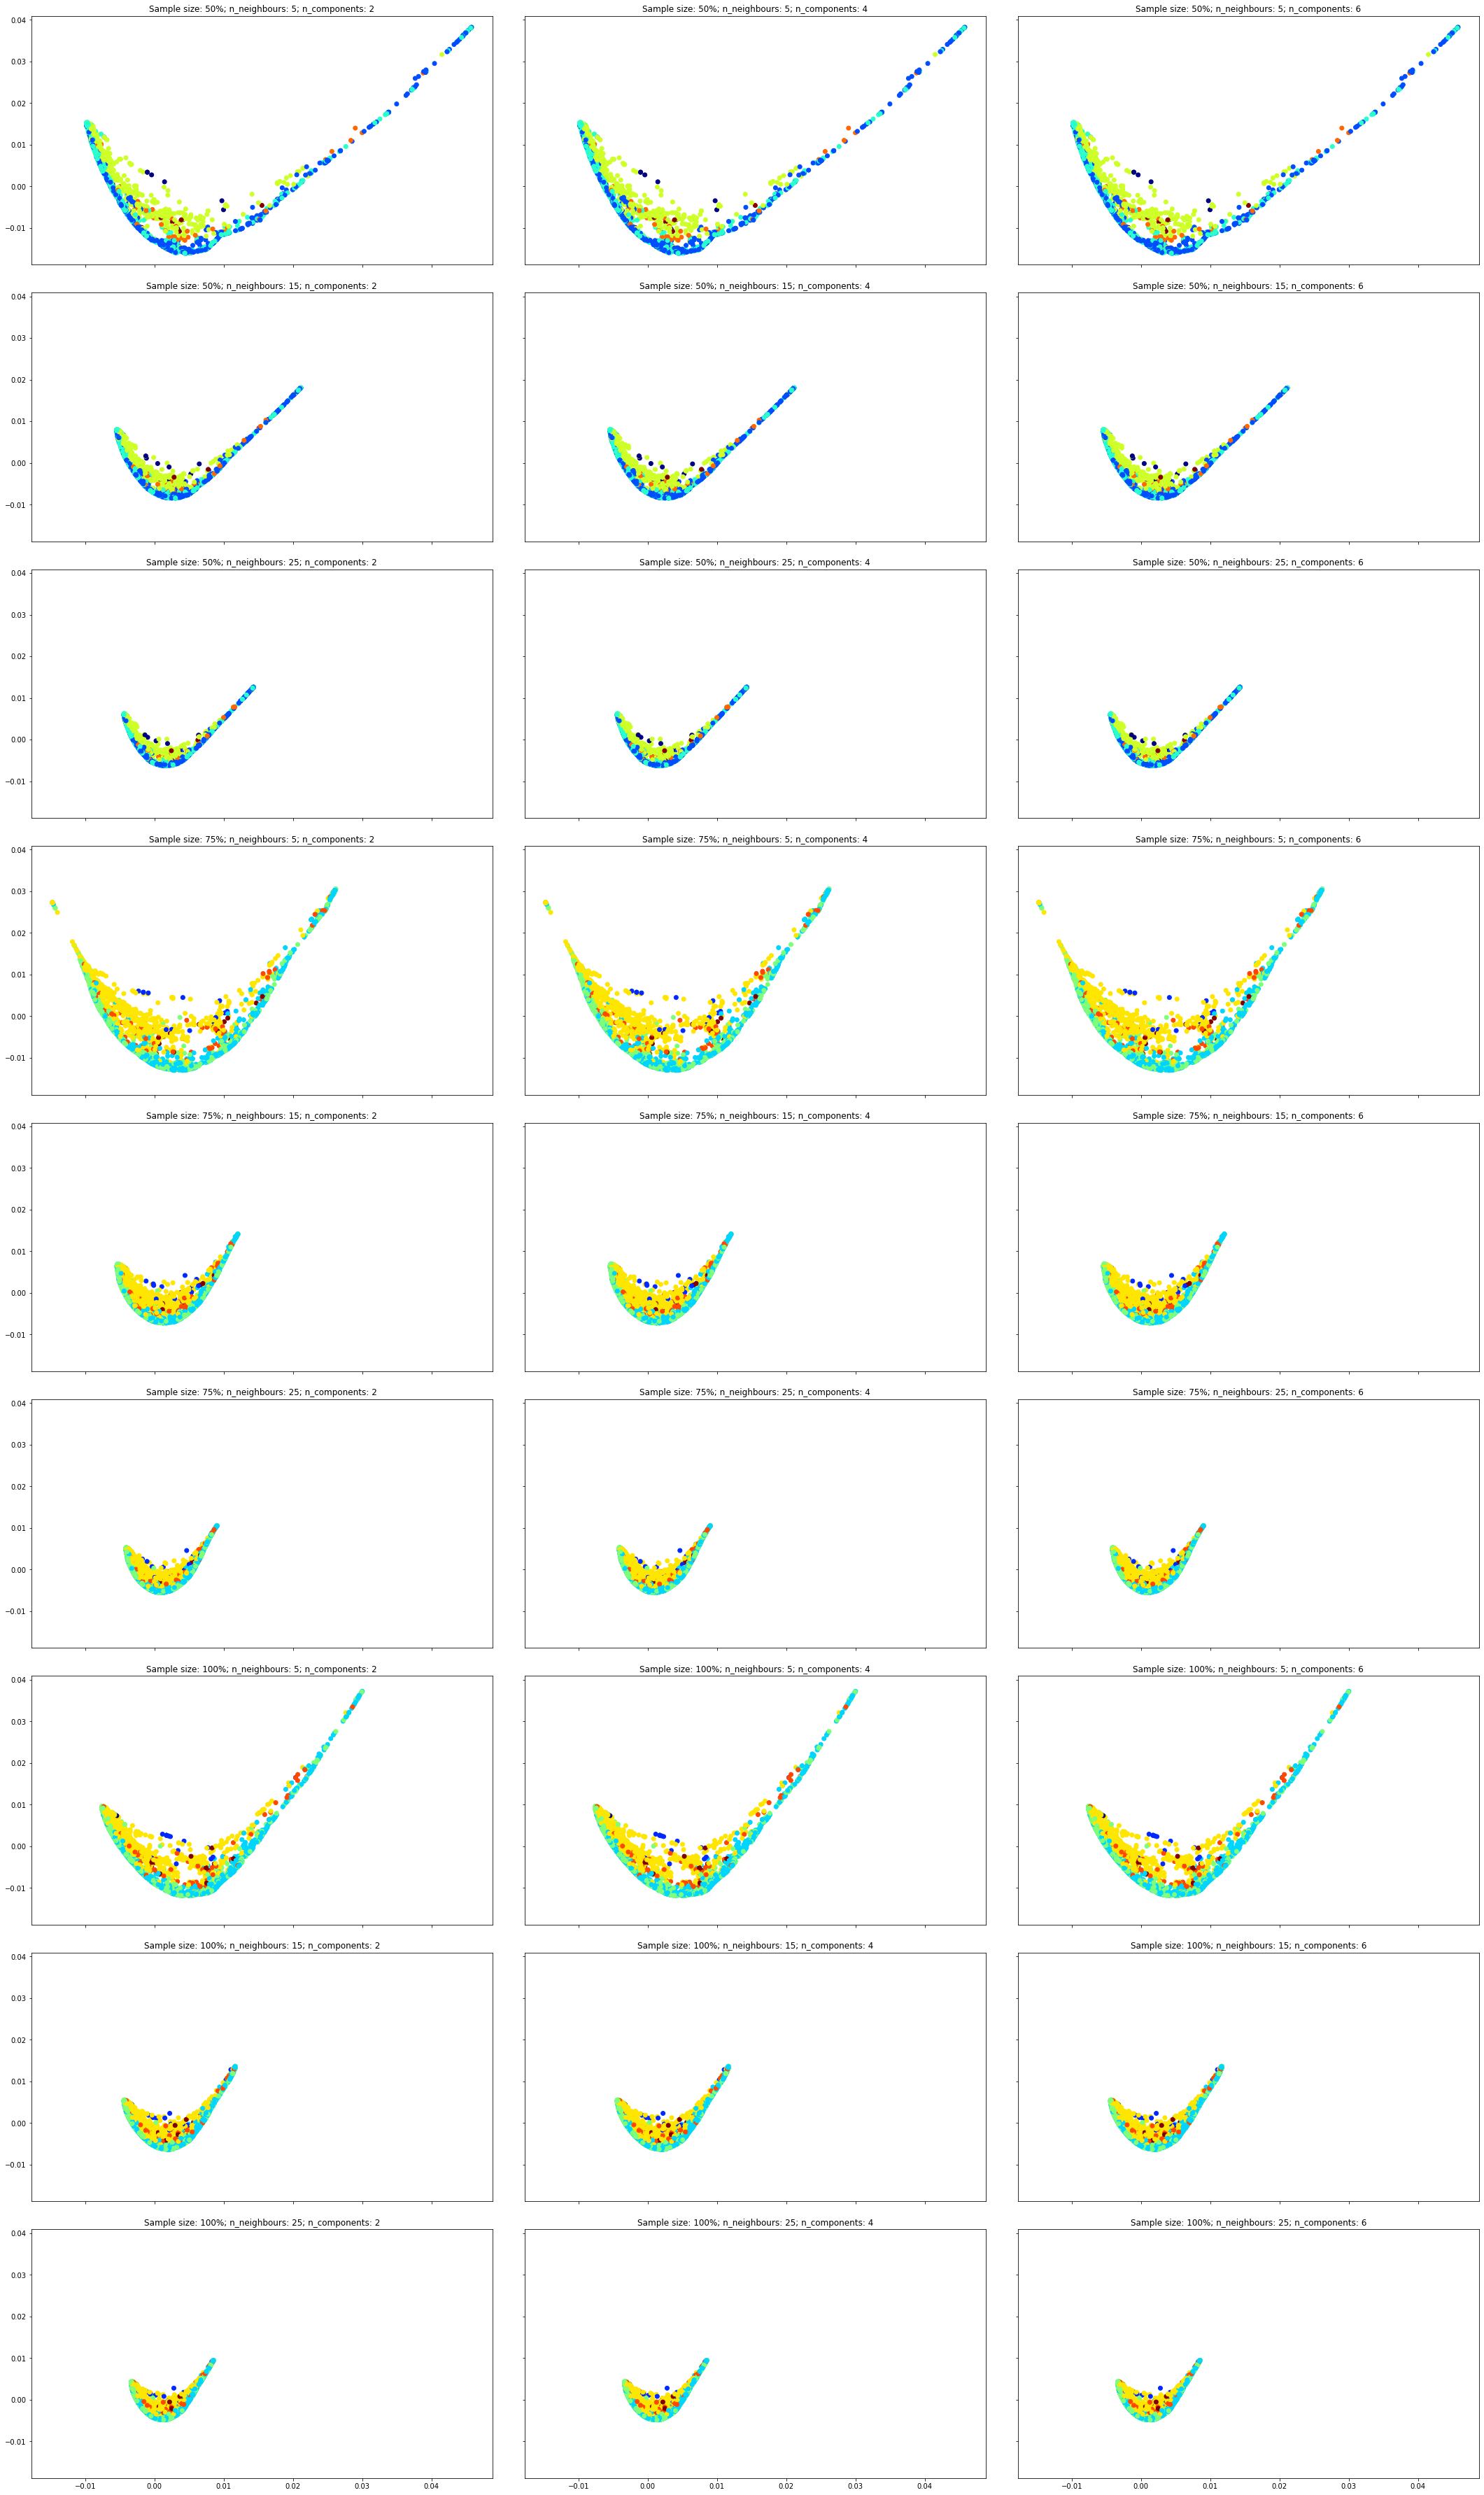

In [28]:
import numpy as np

fig, axes = plt.subplots(ncols=3,nrows=9, sharex=True, sharey=True, figsize=(30, 50));

axes_list = axes.flat

k = 0

fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.2, top=0.95, hspace=0.2)

fig.tight_layout(pad=3.0)

# Components range
min_comps = 2
max_comps = 8
comps_range = range(min_comps, max_comps, 2)


# Neighbours range
min_nbs = 5
max_nbs = 35
nbs_range = range(min_nbs, max_nbs, 10)


# Datasets
sizes = [50,75,100]

for i in sizes:
    df_samp = spectra_df.sample(n = int(len(spectra_df)*(i/100))) # A random sample of size i%
    y_temp = df_samp['y'].values # y values from random sample
    temp_df = df_samp.drop('y', axis=1) # all the x values from random sample
    
    # iterate through number of neighbours
    for n in nbs_range:
        # iterate through number of components
        for c in comps_range:
            
            print("Sample size:", i,"%","n_neighbours:", n, "n_components", c)
            
            title = "Sample size: " + str(i) + "%;" + " " + "n_neighbours: " + str(n) + ";" + " " + "n_components: " + str(c)
            
            se = SpectralEmbedding(n_components=c, n_neighbors=n, random_state=random_state) 
            
            SE_PROJECTION = se.fit_transform(temp_df.values)
            
            X = SE_PROJECTION
            labels = y_temp 
            
            axes_list[k].scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.jet)
            axes_list[k].title.set_text(title) 
            k += 1

### LLE

Sample size: 50 % n_neighbours: 5 n_components 2
 - removing 236 outliers for plot
Sample size: 50 % n_neighbours: 5 n_components 4
 - removing 236 outliers for plot
Sample size: 50 % n_neighbours: 5 n_components 6
 - removing 236 outliers for plot
Sample size: 50 % n_neighbours: 15 n_components 2
 - removing 236 outliers for plot
Sample size: 50 % n_neighbours: 15 n_components 4
 - removing 236 outliers for plot
Sample size: 50 % n_neighbours: 15 n_components 6
 - removing 236 outliers for plot
Sample size: 50 % n_neighbours: 25 n_components 2
 - removing 236 outliers for plot
Sample size: 50 % n_neighbours: 25 n_components 4
 - removing 236 outliers for plot
Sample size: 50 % n_neighbours: 25 n_components 6
 - removing 236 outliers for plot
Sample size: 75 % n_neighbours: 5 n_components 2
 - removing 406 outliers for plot
Sample size: 75 % n_neighbours: 5 n_components 4
 - removing 406 outliers for plot
Sample size: 75 % n_neighbours: 5 n_components 6
 - removing 406 outliers for plo

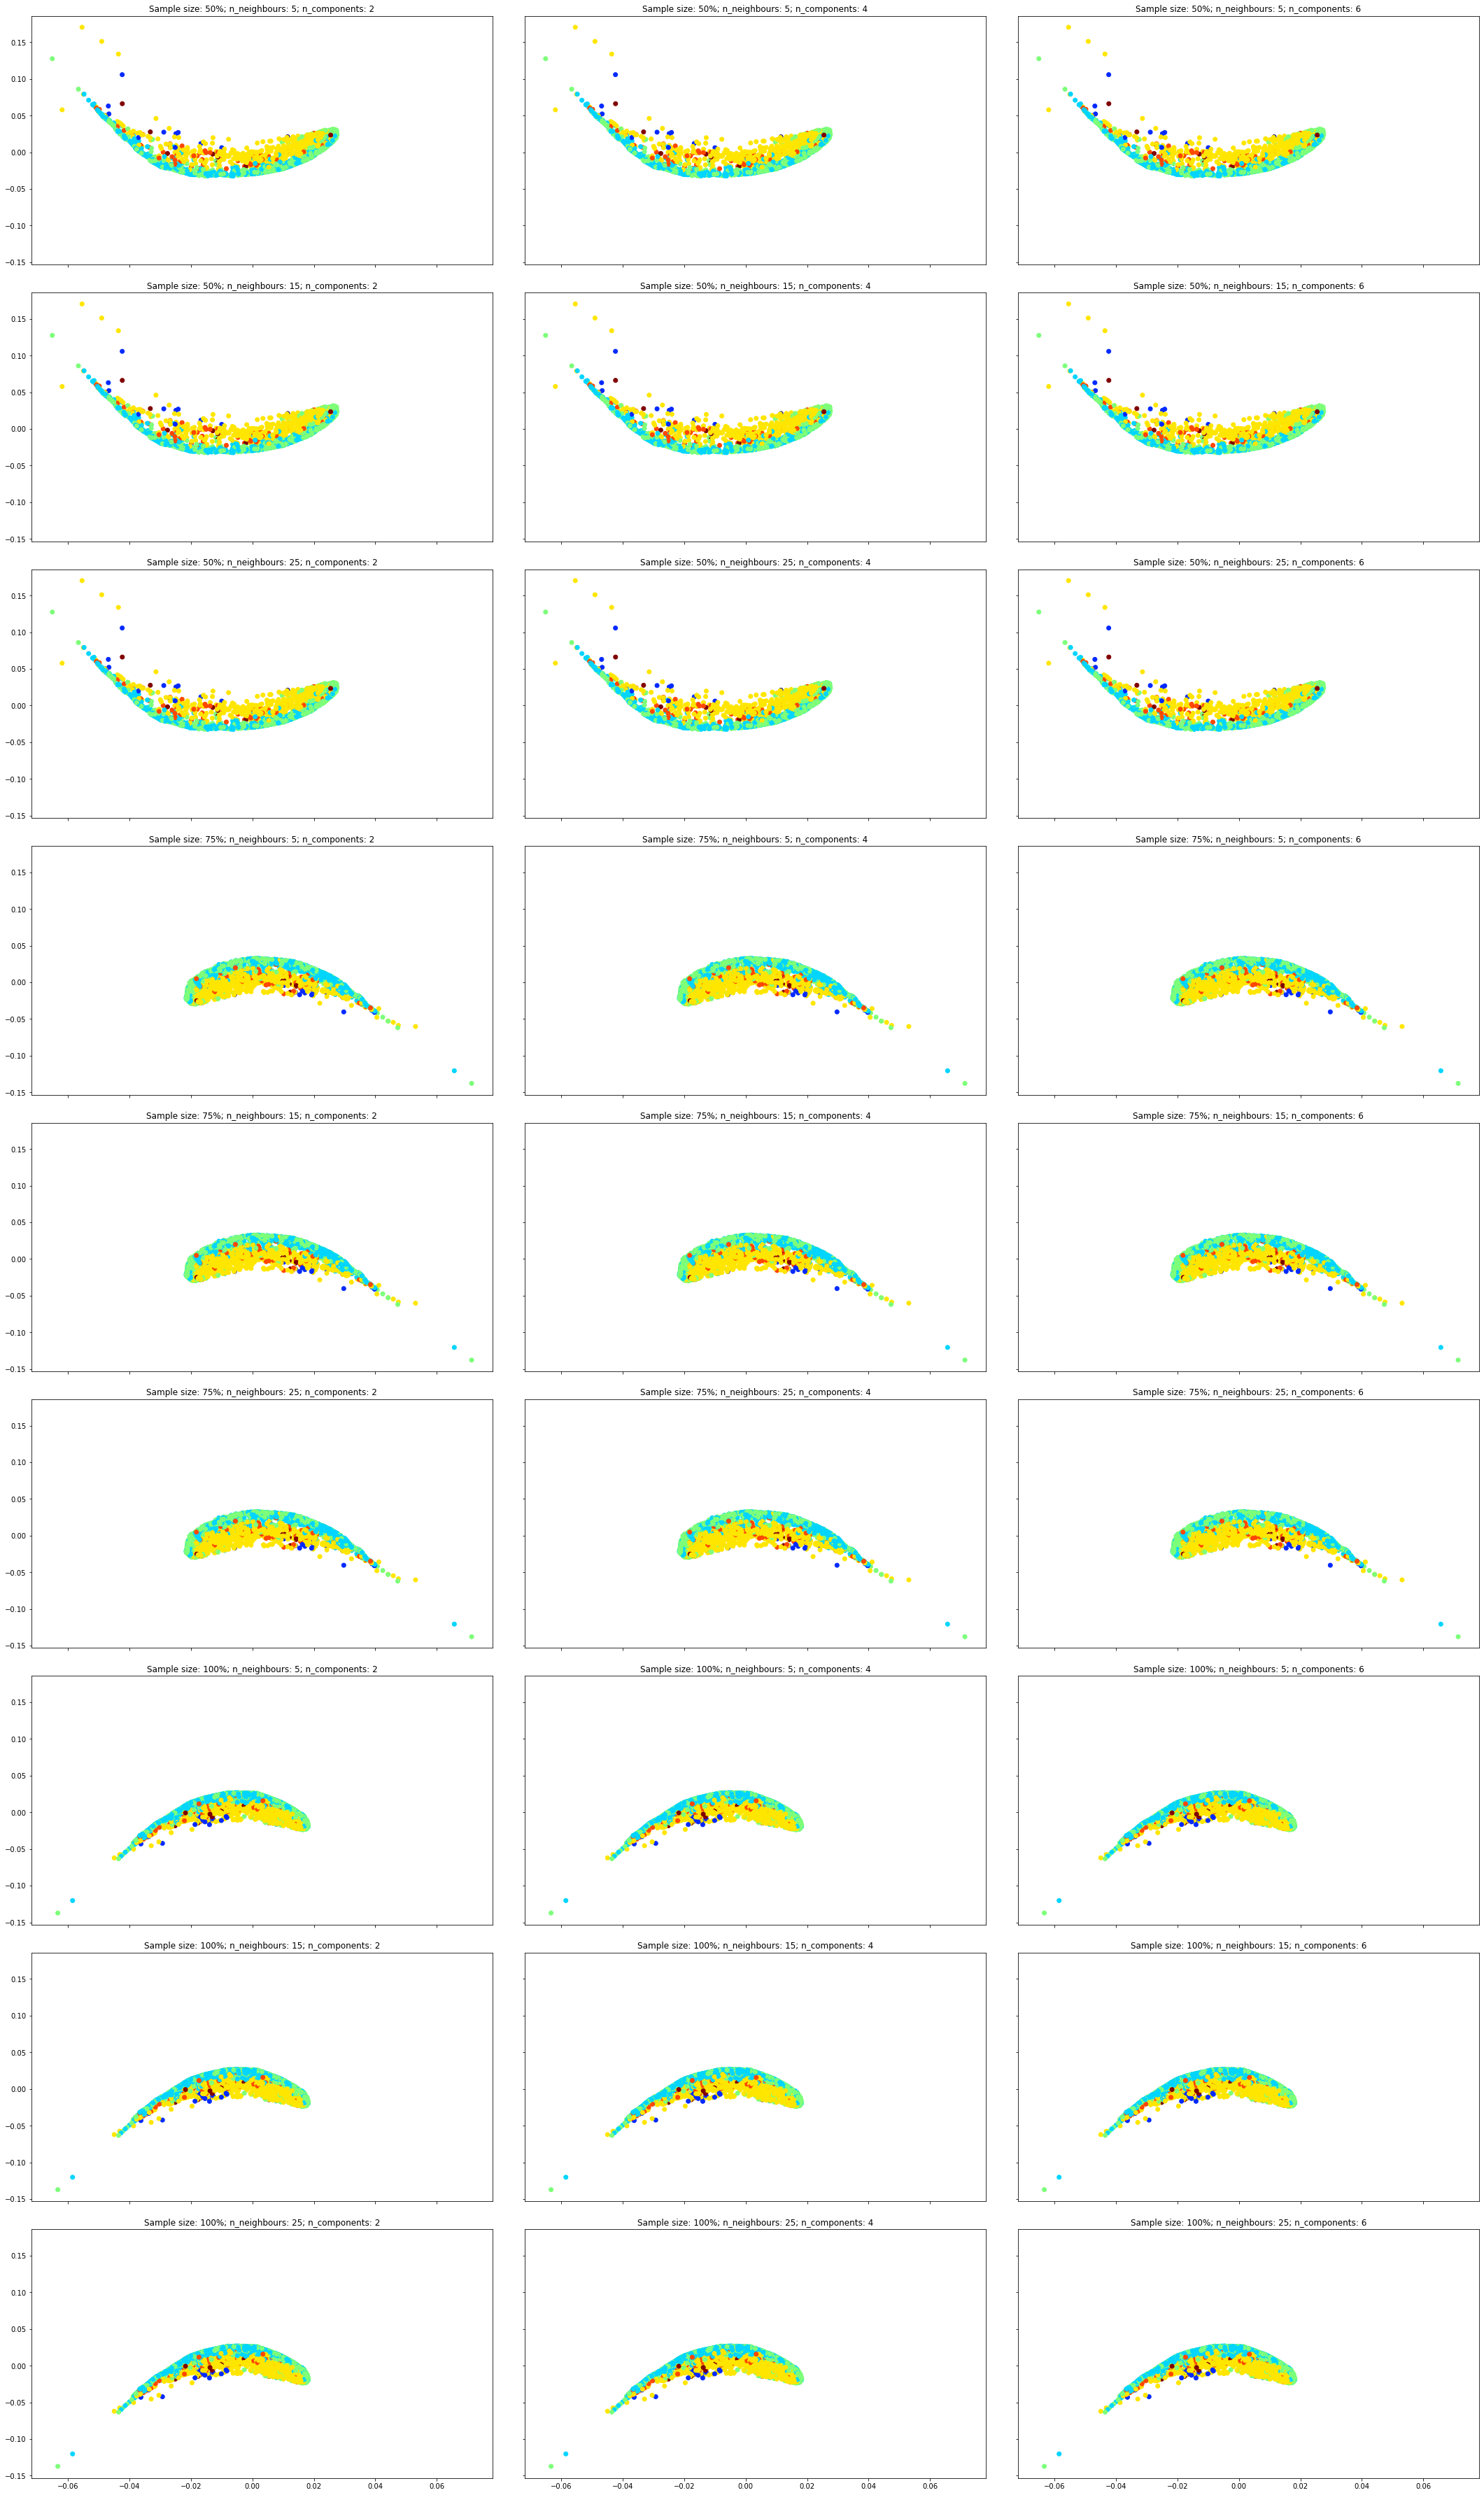

In [29]:
import numpy as np

fig, axes = plt.subplots(ncols=3,nrows=9, sharex=True, sharey=True, figsize=(30, 50));

axes_list = axes.flat

k = 0

fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.2, top=0.95, hspace=0.2)

fig.tight_layout(pad=3.0)

# Components range
min_comps = 2
max_comps = 8
comps_range = range(min_comps, max_comps, 2)


# Neighbours range
min_nbs = 5
max_nbs = 35
nbs_range = range(min_nbs, max_nbs, 10)


# Datasets
sizes = [50,75,100]

for i in sizes:
    df_samp = spectra_df.sample(n = int(len(spectra_df)*(i/100))) # A random sample of size i%
    y_temp = df_samp['y'].values # y values from random sample
    temp_df = df_samp.drop('y', axis=1) # all the x values from random sample
    
    # iterate through number of neighbours
    for n in nbs_range:
        # iterate through number of components
        for c in comps_range:
            # get the coherence score for the given parameters
            
            print("Sample size:", i,"%","n_neighbours:", n, "n_components", c)
            
            title = "Sample size: " + str(i) + "%;" + " " + "n_neighbours: " + str(n) + ";" + " " + "n_components: " + str(c)
            
            lle = LocallyLinearEmbedding(n_components=2, n_neighbors=15, method='modified', eigen_solver='dense', random_state=random_state) 
            
            LLE_PROJECTION = lle.fit_transform(temp_df.values)
            
            # Note: the LLE projection has some outliers that can make the plot
            # look weird.  Use the following to find the mask to remove the outliers
            # for the plot
            flag = mask_outliers(LLE_PROJECTION)
            
            X = LLE_PROJECTION
            labels = y_temp 
            
            axes_list[k].scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.jet)
            axes_list[k].title.set_text(title) 
            k += 1
            


#### 1.1 Dataset size


**1. For the isomap, the size of the dataset did not affect its stability. This was not the case for the umap which projection flipped after the sample size of 50%. When the sample size reached 100%, the projection flipped for lle.**

**2. Spectral embedding is the most stable.**

#### 1.2 Number of neighbours

**1. As the number of neighours increased for spectral embedding, the projection size reduced. The data points were more clustered together. The other methods' stabiliy were not affected by the change in the number of neighbours.**

**2. Umap appears to be the most stable as the points remain in the same postion despite the change in neighbours.**

#### 1.3 Number of components

**1. The number of components did not have any drastic affect on either one of the manifold methods. This could be due to us not evaluating a larger range of values to due computational power.**

**2. The most stable is the lle method, it kept its shape despite any increase in features.**